In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import mean_squared_error, r2_score  

pd.set_option('display.max_rows', None)  # Отображение всех строк  
pd.set_option('display.max_columns', None)  # Отображение всех столбцов  

In [206]:
regions = pd.read_csv('regions.csv')

In [207]:
df = pd.read_csv('starts.csv')
df['event_date'] = pd.to_datetime(df['event_date'])
print(df.columns[20])
df.info()

rain.1h
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178857 entries, 0 to 178856
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   record_id                  178857 non-null  int64         
 1   athlete_id                 178857 non-null  int64         
 2   event_name                 178857 non-null  object        
 3   event_date                 178857 non-null  datetime64[ns]
 4   city                       178857 non-null  object        
 5   region                     178857 non-null  object        
 6   finish_time                178857 non-null  int64         
 7   athlete_gender             178857 non-null  object        
 8   athlete_age                178857 non-null  int64         
 9   is_newbie                  178857 non-null  int64         
 10  temp                       178857 non-null  float64       
 11  feels_like                 178857 non-null  

In [208]:
print('Медианный возраст:', df.athlete_age.quantile(0.5))
print('Медианное кол-во людей в забеге:', df.groupby(['event_name', 'event_date']).agg(cnt_people=('athlete_id', 'nunique')).cnt_people.quantile(0.5))
print('Медианное кол-во пробежек на 1 пользователя:', df.groupby('athlete_id').agg(run_on_person=('athlete_id', 'count')).run_on_person.quantile(0.5))

Медианный возраст: 38.0
Медианное кол-во людей в забеге: 24.0
Медианное кол-во пробежек на 1 пользователя: 2.0


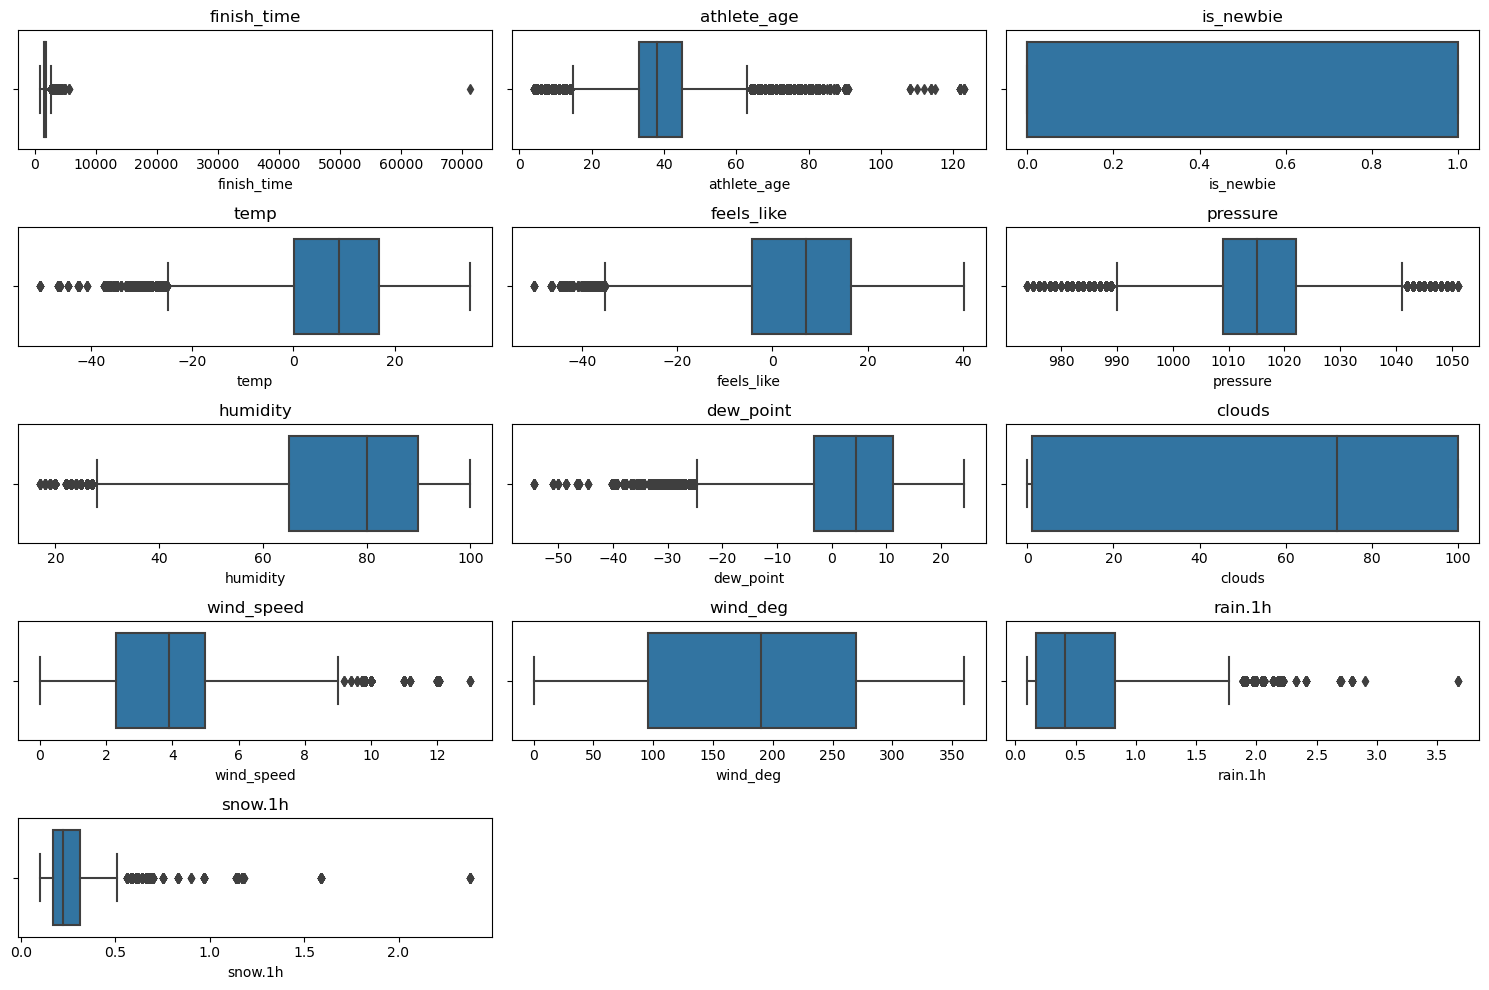

In [209]:
numerical_df = df.select_dtypes(exclude="object")
numerical_df = numerical_df.drop(columns=['record_id', 'athlete_id', 'event_date'])
plt.figure(figsize=(15, 10))  
for i, column in enumerate(numerical_df.columns):  
    plt.subplot(len(numerical_df.columns) // 3 + 1, 3, i + 1)  
    sns.boxplot(x=numerical_df[column])  
    plt.title(column)  

plt.tight_layout()  
plt.show()  

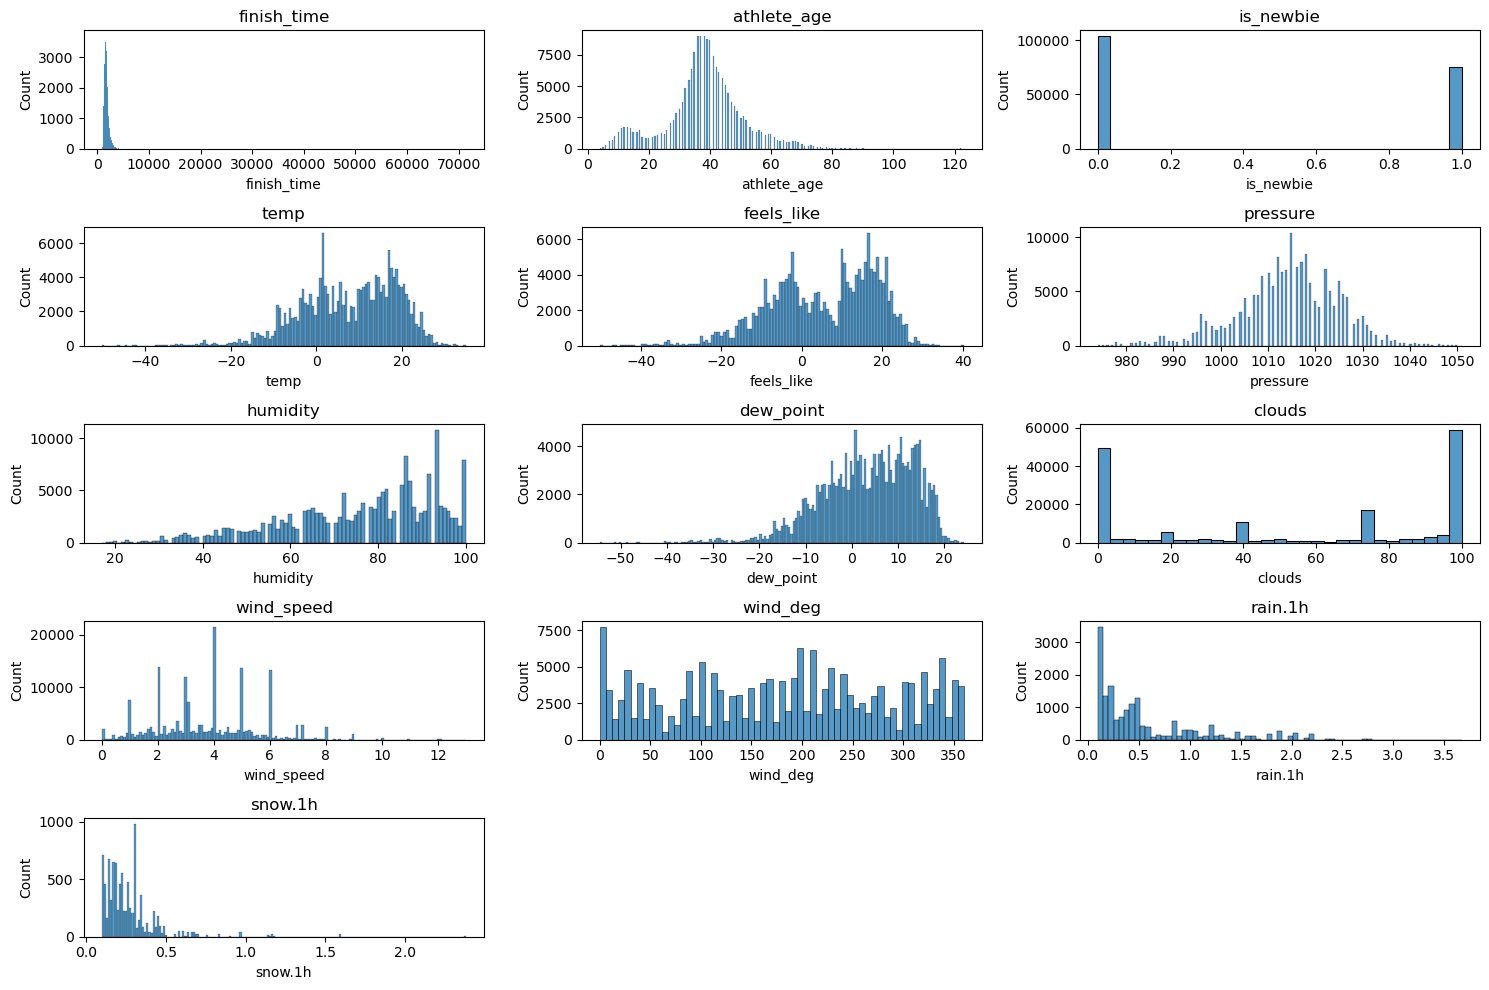

In [210]:
numerical_df = df.select_dtypes(exclude="object")
numerical_df = numerical_df.drop(columns=['record_id', 'athlete_id', 'event_date'])
plt.figure(figsize=(15, 10))  
for i, column in enumerate(numerical_df.columns):  
    plt.subplot(len(numerical_df.columns) // 3 + 1, 3, i + 1)  
    sns.histplot(x=numerical_df[column])  
    plt.title(column)  

plt.tight_layout()  
plt.show()  

In [211]:
outliers = pd.DataFrame(columns=['Переменная', 'Нижняя граница', 'Верхняя граница', 'IQR', 'Количество выбросов'])
for column in numerical_df.columns:
    q1 = numerical_df[column].quantile(0.25)  # 25-й процентиль
    q3 = numerical_df[column].quantile(0.75)  # 75-й процентиль
    iqr = q3 - q1
    outliers = pd.concat([outliers, pd.DataFrame([{'Переменная': column, 'Нижняя граница': q1 - 1.5 * iqr, 'Верхняя граница': q3 + 1.5 * iqr, 'IQR': iqr, 'Количество выбросов': df[(df[column] > q3 + 1.5 * iqr) | (df[column] < q1 - 1.5 * iqr)].shape[0]}])], ignore_index=True)
outliers

,Переменная,Нижняя граница,Верхняя граница,IQR,Количество выбросов
0,finish_time,741.500,2665.500,481.00,6484
1,athlete_age,15.000,63.000,12.00,16297
2,is_newbie,-1.500,2.500,1.00,0
3,temp,-24.960,42.080,16.76,1419
4,feels_like,-35.155,47.445,20.65,595
5,pressure,989.500,1041.500,13.00,5287
6,humidity,27.500,127.500,25.00,920
7,dew_point,-24.960,33.040,14.50,1897
8,clouds,-147.500,248.500,99.00,0
9,wind_speed,-1.725,9.035,2.69,624


Удалим всех людей, которые шли шагом или медленее (5 км/ч)

In [212]:
new_df = df[df['finish_time'] < 3600]

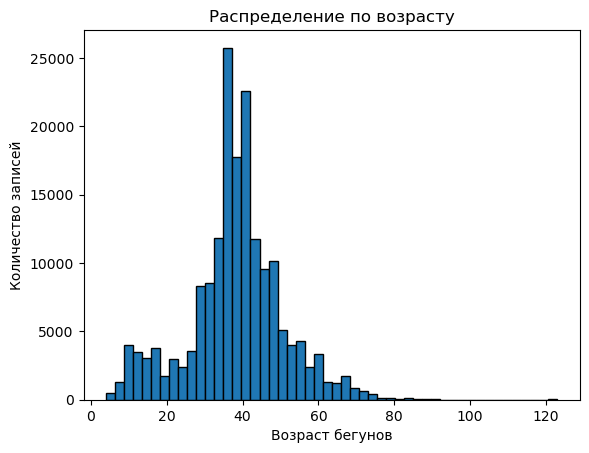

In [213]:
plt.hist(new_df['athlete_age'], bins=50, edgecolor='black')
plt.title('Распределение по возрасту')
plt.xlabel('Возраст бегунов')
plt.ylabel('Количество записей')
plt.show()

На распределении видно, что выбросами являются участники старше 80 лет

In [214]:
new_df = new_df[new_df['athlete_age'] < 80]

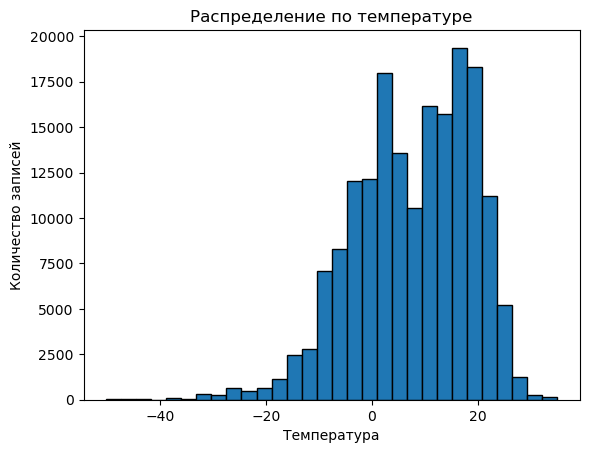

In [215]:
plt.hist(new_df['temp'], bins=30, edgecolor='black')
plt.title('Распределение по температуре')
plt.xlabel('Температура')
plt.ylabel('Количество записей')
plt.show()

In [216]:
low_temp_df = new_df[new_df['temp'] < -23]

In [217]:
low_temp_df.loc[:, 'month'] = low_temp_df['event_date'].dt.month

C:\Users\1\AppData\Local\Temp\ipykernel_4648\2967033106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_temp_df.loc[:, 'month'] = low_temp_df['event_date'].dt.month


In [218]:
low_temp_df['month'].value_counts()

month
12    825
1     804
2     112
3       9
Name: count, dtype: int64

In [219]:
low_temp_df[low_temp_df['month'] == 3]

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,month
31336,5975,790079611,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1826,женский,37,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
63699,5975,790104282,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1490,мужской,56,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
74357,5975,790110203,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1486,мужской,45,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
74460,5975,790110215,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1689,мужской,43,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
74533,5975,790110219,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1805,мужской,43,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
83487,5975,790113808,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1715,мужской,36,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
87402,5975,790115431,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1837,женский,47,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
116802,5975,790127743,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1621,мужской,24,1,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
119581,5975,790128597,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1480,мужской,35,1,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3


4-ого марта в Воркуте действительно была такая температура

In [220]:
super_low_temp_df = new_df[new_df['temp'] < -40]
super_low_temp_df['city'].unique()

array(['Якутск'], dtype=object)

В Якутске действительно очень холодно, поэтому в переменной temp нет выбросов. Тоже самое с переменной feels like

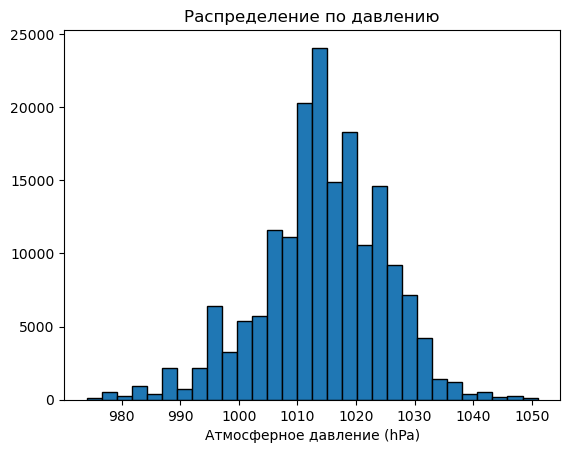

In [221]:
plt.hist(new_df['pressure'], bins=30, edgecolor='black')
plt.title('Распределение по давлению')
plt.xlabel('Атмосферное давление (hPa)')
plt.show()

В давлении нет выбросов

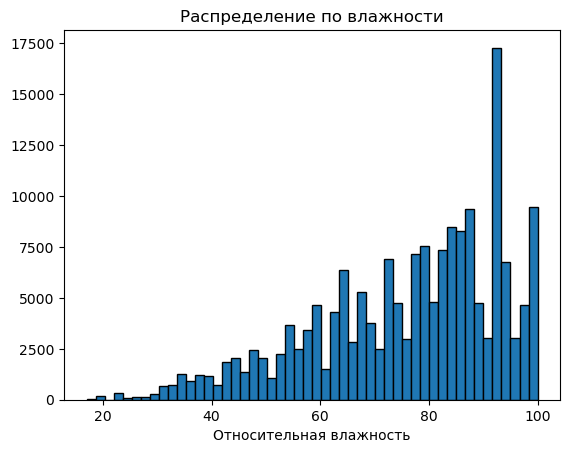

In [222]:
plt.hist(new_df['humidity'], bins=50, edgecolor='black')
plt.title('Распределение по влажности')
plt.xlabel('Относительная влажность')
plt.show()

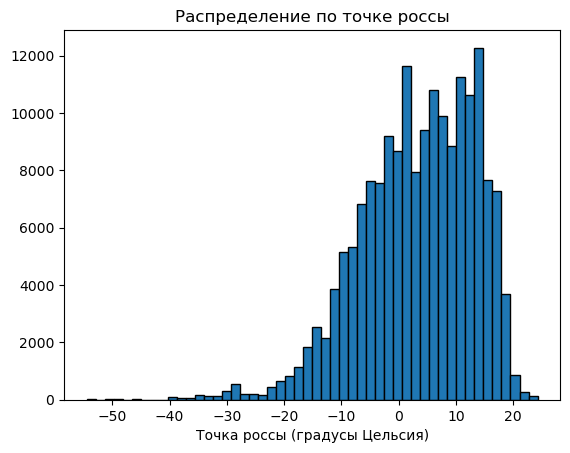

In [223]:
plt.hist(new_df['dew_point'], bins=50, edgecolor='black')
plt.title('Распределение по точке россы')
plt.xlabel('Точка россы (градусы Цельсия)')
plt.show()

In [224]:
new_df[new_df['dew_point'] < -40]['city'].value_counts()

city
Якутск         84
Новосибирск    17
Иркутск        16
Томск          15
Name: count, dtype: int64

In [225]:
super_low_point = new_df[new_df['dew_point'] < -40]
super_low_point.loc[:, 'month'] = super_low_point['event_date'].dt.month
super_low_point['month'].value_counts()

C:\Users\1\AppData\Local\Temp\ipykernel_4648\1467462739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super_low_point.loc[:, 'month'] = super_low_point['event_date'].dt.month


month
12    74
1     52
2      6
Name: count, dtype: int64

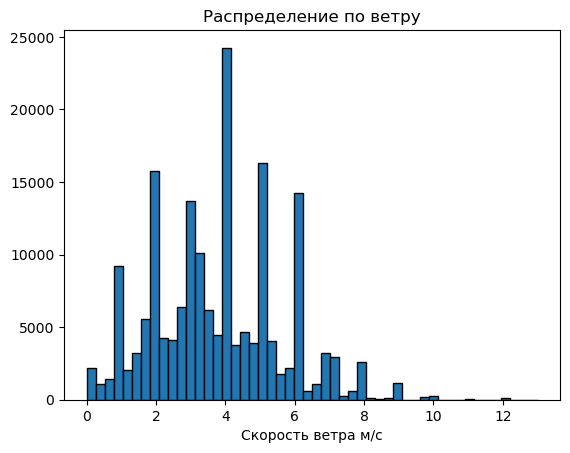

In [226]:
plt.hist(new_df['wind_speed'], bins=50, edgecolor='black')
plt.title('Распределение по ветру')
plt.xlabel('Скорость ветра м/с')
plt.show()

In [227]:
new_df['city'][new_df['wind_speed'] > 10].value_counts()

city
Екатеринбург    52
Томск           41
Челябинск       41
Кемерово        22
Омск            14
Калуга          12
Чебоксары       11
Орск            11
Железноводск     7
Name: count, dtype: int64

Вполне вероятно, что эти значенияя не выбросы, так как большинство этих городов являются ветреными

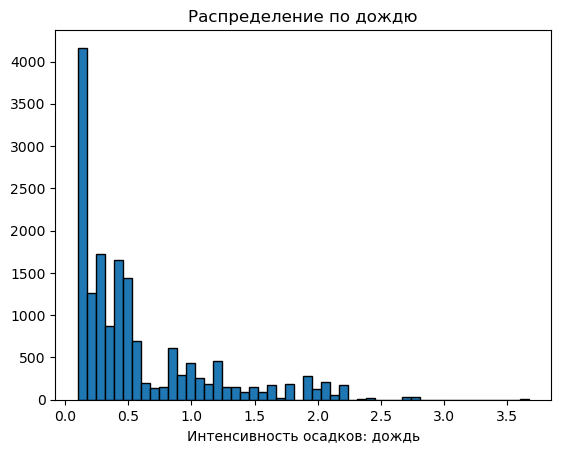

In [228]:
plt.hist(new_df['rain.1h'], bins=50, edgecolor='black')
plt.title('Распределение по дождю')
plt.xlabel('Интенсивность осадков: дождь')
plt.show()

Что-то очень странно, GPT говорит, что так распределяется:
Слабый дождь: до 2,5 мм/час.
Умеренный дождь: от 2,5 до 7,6 мм/час.
Сильный дождь: от 7,6 мм/час и выше.
Ливень: более 50 мм/час.

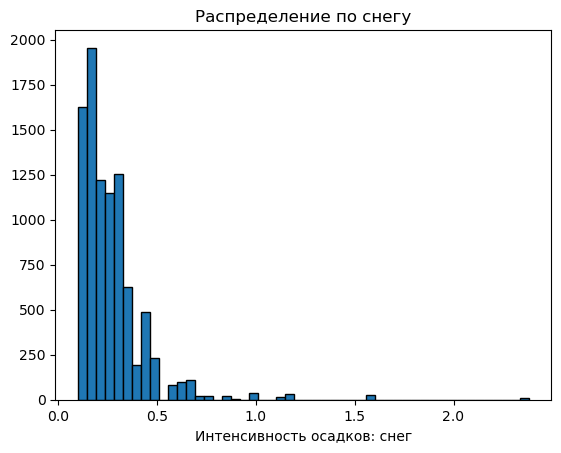

In [229]:
plt.hist(new_df['snow.1h'], bins=50, edgecolor='black')
plt.title('Распределение по снегу')
plt.xlabel('Интенсивность осадков: снег')
plt.show()

Выбросов нет

Далее Максим делает

In [230]:
#ДАЛЕЕ МАКСИМ делает

new_df[new_df['snow.1h'] > 2.0]

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface
34394,11991,790081423,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1876,женский,63,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
34490,11991,790081527,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1422,мужской,46,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
34703,11991,790081745,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1492,мужской,37,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
36424,11991,790083775,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1553,мужской,41,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
45317,11991,790091739,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1460,мужской,32,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
77613,11991,790111187,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1653,мужской,54,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
107588,11991,790124655,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1875,мужской,52,1,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
163588,11991,790148503,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,2572,женский,36,1,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
168843,11991,790151957,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,2574,женский,46,1,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт


РАССМОТРЕНИЕ МЕДИАННЫХ ЗНАЧЕНИЙ ДОБАВИЛ В НАЧАЛО БЛОКНОТА


щас еще распределения посмотрим...

Text(0.5, 1.0, 'Распределение кол-ва новичков по регионам')

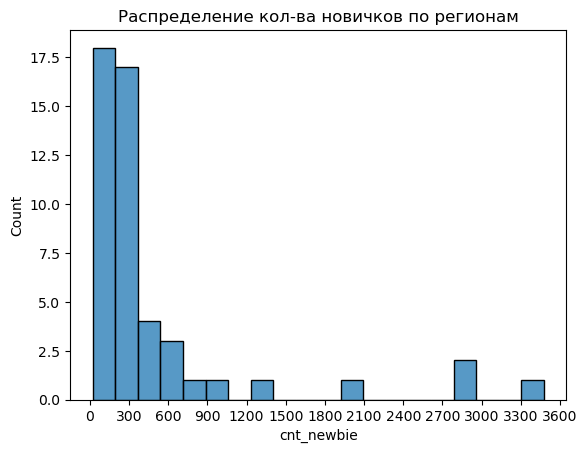

In [231]:
newbie_by_region = new_df.drop_duplicates(['athlete_id', 'region']).groupby('region').agg(cnt_newbie = ('athlete_id', lambda x: len(x[new_df.is_newbie == 1])))

plt.xticks([i for i in range(0, 4000, 300)])
sns.histplot(x=newbie_by_region.cnt_newbie)

plt.title('Распределение кол-ва новичков по регионам')

Text(0.5, 1.0, 'Распределение кол-ва зарегистрировашихся до 2023 г. по регионам')

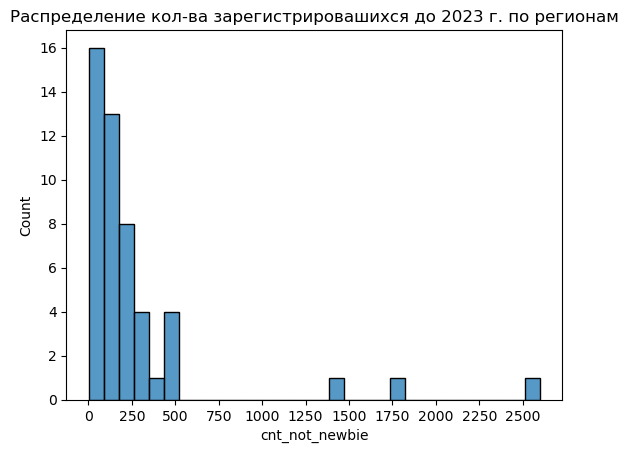

In [232]:
not_newbie_by_region = new_df.drop_duplicates(['athlete_id', 'region']).groupby('region').agg(cnt_not_newbie = ('athlete_id', lambda x: len(x[new_df.is_newbie == 0])))
plt.xticks([i for i in range(0, 3000, 250)])
sns.histplot(x=not_newbie_by_region.cnt_not_newbie)
plt.title('Распределение кол-ва зарегистрировашихся до 2023 г. по регионам')

Text(0.5, 1.0, 'Распределение кол-ва уникальных бегунов по регионам')

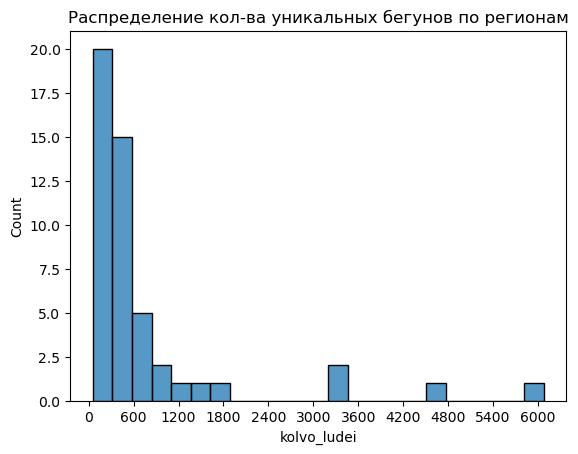

In [233]:
unique_runners = new_df.drop_duplicates(subset=['region', 'athlete_id']).groupby('region').athlete_id.count().reset_index(name='kolvo_ludei')
plt.xticks([i for i in range(0, 6200, 600)])
sns.histplot(x=unique_runners.kolvo_ludei)
plt.title('Распределение кол-ва уникальных бегунов по регионам')

Text(0.5, 1.0, 'Распределение ДОЛИ новичков от всех уник. бегунов в регионе')

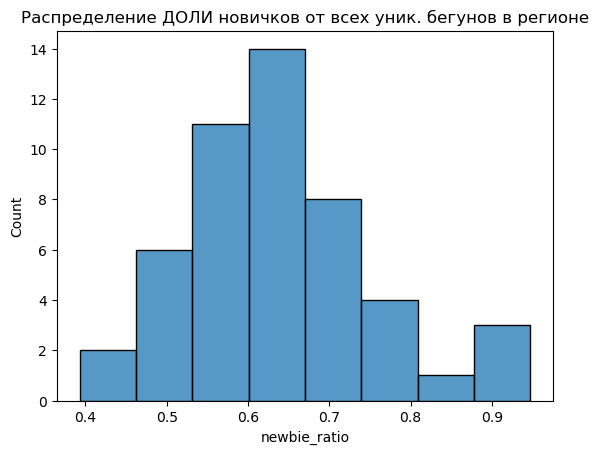

In [234]:
unique_runners = new_df.drop_duplicates(subset=['region', 'athlete_id'])
newbie_ratios = (
    unique_runners
    .groupby('region', as_index=False)
    .agg(newbie_ratio=('is_newbie', lambda x: x.sum() / len(x)))
)

sns.histplot(newbie_ratios.newbie_ratio)
plt.title('Распределение ДОЛИ новичков от всех уник. бегунов в регионе')

Text(0.5, 1.0, 'Кол-во проведенных пробежек по регионам')

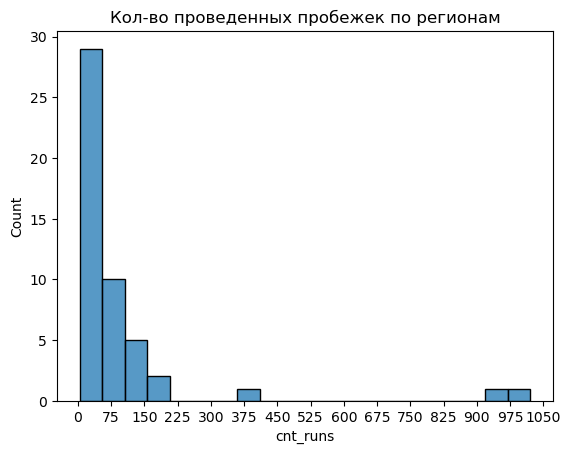

In [235]:
runs_by_region = new_df.drop_duplicates(['event_name', 'event_date']).groupby('region').event_date.count().reset_index(name="cnt_runs")

plt.xticks([i for i in range(0, 1100, 75)])
sns.histplot(x=runs_by_region.cnt_runs, bins=20)
plt.title('Кол-во проведенных пробежек по регионам')


<Axes: title={'center': 'Распределение пола среди всех уникальных бегунов'}, xlabel='athlete_gender', ylabel='cnt'>

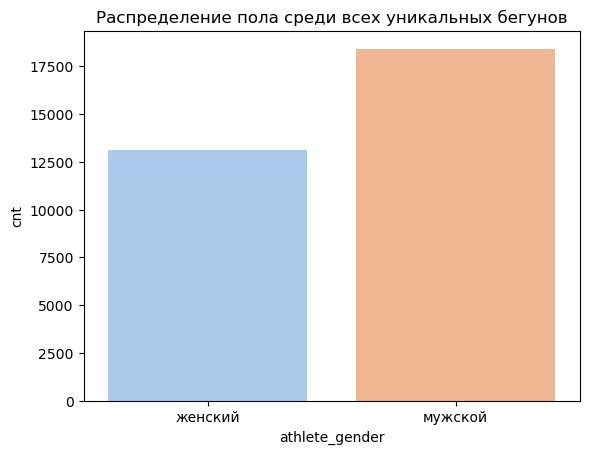

In [236]:
unique_runners = new_df.drop_duplicates(subset=['athlete_id'])
gender_newbie = unique_runners.groupby('athlete_gender').agg(
    cnt=('athlete_id', 'nunique')
).reset_index()

plt.title('Распределение пола среди всех уникальных бегунов')
sns.barplot(data=gender_newbie, x='athlete_gender', y='cnt', palette='pastel')

<Axes: title={'center': 'Распределение пола среди всех уникальных newbie'}, xlabel='athlete_gender', ylabel='cnt'>

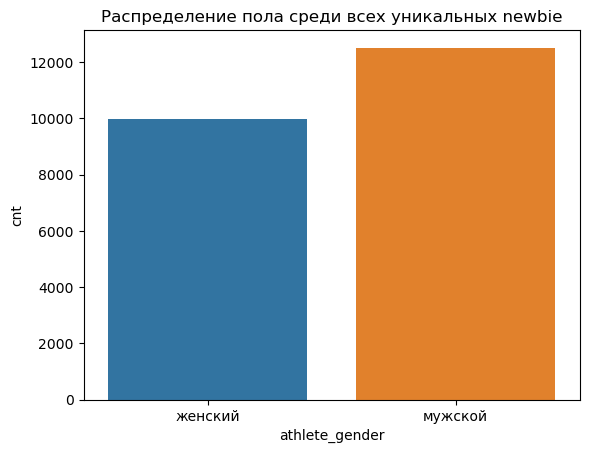

In [237]:
unique_runners = new_df.drop_duplicates(subset=['athlete_id'])
gender_newbie = unique_runners[unique_runners.is_newbie==1].groupby('athlete_gender').agg(
    cnt=('athlete_id', 'nunique')
).reset_index()

plt.title('Распределение пола среди всех уникальных newbie')
sns.barplot(data=gender_newbie, x='athlete_gender', y='cnt')

Далее я хочу посмотреть дату первой и последней пробежки в 2023 году по регионам

In [238]:
first_last_run = new_df.groupby(['region']).agg(
    first_run_in_2023 = ('event_date', 'min'),
    last_run_in_2023 = ('event_date', 'last')
).reset_index()

first_last_run

,region,first_run_in_2023,last_run_in_2023
0,Архангельская область,2023-06-17,2023-12-30
1,Астраханская область,2023-01-07,2023-12-30
2,Белгородская область,2023-01-07,2023-12-30
3,Владимирская область,2023-01-01,2023-12-23
4,Волгоградская область,2023-01-01,2023-12-30
5,Воронежская область,2023-01-01,2023-12-30
6,Иркутская область,2023-01-07,2023-12-23
7,Калининградская область,2023-01-01,2023-12-30
8,Калужская область,2023-01-07,2023-12-30
9,Кемеровская область,2023-01-07,2023-12-30


Все регионы уже участвовали в 5 верст, КРОМЕ: 
1) Архангельская область	(зашла в июне)
2) Липецкая область (в июле)
3) Республика Адыгея (в ноябре)
4) Республика Карелия (в декабре)
5) Сахалинская область (в августе)

И что из этого следует? Что в этих регионах будет очень высокая доля новичков, раз 5 верст зашли в них во второй половине 2023 года (а в некоторых под конец года). Но почему же тогда в этих регионах не 100% newbie_ratio? а все потому что, есть люди которые мб просто так зарегистрировались до 2023 года и узнали что их региона нет в 5 верст ИЛИ они участвовали в другом регионе до 2023 и тогда зарегистрировались

In [239]:
newbie_ratios.sort_values(by='newbie_ratio',ascending=False).head(6)

,region,newbie_ratio
26,Республика Адыгея,0.947368
28,Республика Карелия,0.935484
16,Липецкая область,0.934037
44,Тюменская область,0.859109
37,Сахалинская область,0.794118
0,Архангельская область,0.781250


в Топ-6 newbie_ratio - входят как раз таки эти регионы в которые 5 верст зашла в этом 2023 году( а точнее во второй половине 23 года)
Только тюменская область тут оказалась как-то. 

In [240]:
unique_runners = new_df.drop_duplicates(subset=['region', 'athlete_id'])
adigeya = unique_runners[(unique_runners.region == 'Республика Адыгея')]
print('кол-во участников в адыгее уникальных: ', len(adigeya))
display(adigeya[adigeya.is_newbie == 0])

кол-во участников в адыгее уникальных:  57


,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface
45917,13157,790092280,Майкоп Городской парк,2023-12-02,Майкоп,Республика Адыгея,2058,мужской,42,0,16.32,15.84,1013,70,10.84,26,7.07,214,Clouds,scattered clouds,NaN,NaN,твердое
83791,13157,790113919,Майкоп Городской парк,2023-12-02,Майкоп,Республика Адыгея,1979,мужской,34,0,16.32,15.84,1013,70,10.84,26,7.07,214,Clouds,scattered clouds,NaN,NaN,твердое
89610,13157,790116283,Майкоп Городской парк,2023-12-02,Майкоп,Республика Адыгея,1417,женский,33,0,16.32,15.84,1013,70,10.84,26,7.07,214,Clouds,scattered clouds,NaN,NaN,твердое


Из 57 уникальных бегунов в адыгее (куда 5 верст зашли в ноябре) 3 человека уже зарегистрированы до 23 года были. щас посмотрим что это за люди.

In [241]:
new_df[new_df.athlete_id == 790116283].head(7)


,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface
89593,5156,790116283,Солнечный остров,2023-01-21,Краснодар,Краснодарский край,2902,женский,32,0,2.08,2.08,1020,80,-0.89,0,1.00,0,Clear,clear sky,NaN,NaN,твердое
89594,5310,790116283,Солнечный остров,2023-01-28,Краснодар,Краснодарский край,1570,женский,32,0,-1.92,-5.81,1012,80,-4.56,0,3.00,60,Clear,clear sky,NaN,NaN,твердое
89595,5881,790116283,Солнечный остров,2023-02-25,Краснодар,Краснодарский край,1576,женский,32,0,1.80,-1.44,1014,64,-3.79,0,3.13,110,Clear,clear sky,NaN,NaN,твердое
89596,6150,790116283,Солнечный остров,2023-03-11,Краснодар,Краснодарский край,1559,женский,32,0,10.71,9.82,1008,76,6.66,0,3.13,120,Clear,clear sky,NaN,NaN,твердое
89597,6991,790116283,Солнечный остров,2023-04-15,Краснодар,Краснодарский край,1646,женский,32,0,13.78,12.73,1017,58,5.67,0,3.13,320,Clear,clear sky,NaN,NaN,твердое
89598,7615,790116283,Солнечный остров,2023-05-13,Краснодар,Краснодарский край,1476,женский,33,0,15.22,14.34,1018,59,7.27,0,6.00,60,Clear,clear sky,NaN,NaN,твердое
89599,7810,790116283,Солнечный остров,2023-05-20,Краснодар,Краснодарский край,1459,женский,33,0,21.71,21.22,1014,49,10.54,26,7.15,80,Clouds,scattered clouds,NaN,NaN,твердое


Моя теория подтвердилась, эти люди участвовали в других регионах(которые до 2023 года в 5 верст) и поэтому уже были зарегистрированы до 23 года а потом оказались как то в сахалинской области

Лично мое мнение, что эти новые регионы придется откинуть(слава богу их 5 штук), тк 5 верст в них меньше полугода (а в некоторых вообще меньше 2 месяцев)


In [242]:
old_regions = new_df[~new_df['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]  

In [243]:
#повторим подсчеты все уже с old_regions (в которых 5 верст до 2023 года)
data = old_regions.merge(regions, on='region', how='left')
unique_runners = data.drop_duplicates(subset=['region', 'athlete_id'])
newbie_ratios = (
    unique_runners
    .groupby('region', as_index=False)
    .agg(newbie_ratio=('is_newbie', lambda x: x.sum() / len(x)))
)
reg = newbie_ratios.merge(regions, how='left', on='region')
print(len(reg)) #было 49 регионов, удалили 5 новых регионов, стало 44 региона

44


Семён: Пересчитаем факторы

In [244]:
#Семён
reg['crimes_per_1000'] = reg['crimes_murder_attempts'] + reg['crimes_drug_related'] + reg['crimes_grievous_bodily_harm'] + reg['crimes_robbery'] + reg['crimes_armed_robbery'] + reg['crimes_hooliganism']
reg['crimes_per_1000'] = reg['crimes_per_1000'] / reg['population_total'] 
reg = reg.drop(columns=['crimes_grievous_bodily_harm', 'crimes_murder_attempts', 'crimes_drug_related', 'crimes_robbery', 'crimes_armed_robbery', 'crimes_hooliganism'])

reg['library_users_per_1'] = reg['library_users_total'] / reg['population_total']
reg = reg.drop(columns=['library_users_total'])

reg['qualified_workers_grads_per_1'] = reg['qualified_workers_grads'] / reg['population_total']
reg['bachelors_specialists_masters_grads_per_1'] = reg['bachelors_specialists_masters_grads'] / reg['population_total']
reg['mid_level_specialists_grads_per_1'] = reg['mid_level_specialists_grads'] / reg['population_total']
reg = reg.drop(columns=['qualified_workers_grads', 'bachelors_specialists_masters_grads', 'mid_level_specialists_grads'])

reg['sports_facilities_fields_per_1000'] = reg['sports_facilities_fields'] / reg['population_total']
reg['sports_facilities_gyms_per_1000'] = reg['sports_facilities_gyms'] / reg['population_total']
reg = reg.drop(columns=['sports_facilities_fields', 'sports_facilities_gyms'])

Теперь построим новую матрцу корреляций предварительно откинув не стат значимые переменные

In [245]:
# Максим
reg['air_pollutant_relative_per_1000_person'] = reg['air_pollutant_emissions'] / reg['population_total'] * 1000
reg = reg.drop(columns=['air_pollutant_emissions'])
# Фильтруем только целочисленные столбцы  
integer_columns = reg.select_dtypes(include=['number']).columns  

# Переменная для хранения незначимых переменных  
insignificant_vars = []  

# Обходим все целочисленные столбцы  
for col in integer_columns:  
    
    try:
        if col != 'newbie_ratio':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(reg[col], reg['newbie_ratio'])  
        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))
# Удаляем незначимые переменные (по корреляции) из датафрейма  
reg = reg.drop(columns=insignificant_vars)  


Неподходящие целочисленные переменные: ['per_capita_income_rub', 'median_income_per_capita_rub', 'milk_consumption_per_capita', 'sugar_consumption_per_capita', 'urban_population_pct', 'working_age_population_pct', 'dependency_ratio', 'death_rate_per_1000', 'marriage_rate_per_1000', 'migration_increase_rate_per_10000', 'forest_coverage_pct', 'disease_incidence_infectious', 'disease_incidence_cancer', 'disease_incidence_endocrine', 'disease_incidence_nervous', 'disease_incidence_eye', 'disease_incidence_ear', 'disease_incidence_circulatory', 'disease_incidence_respiratory', 'disease_incidence_digestive', 'disease_incidence_skin', 'disease_incidence_musculoskeletal', 'disease_incidence_genitourinary', 'disease_incidence_congenital', 'disease_incidence_trauma', 'disease_incidence_all', 'captured_air_pollutants_pct', 'wastewater_discharge', 'personal_computer_households_pct', 'daily_internet_usage_pct', 'bus_passenger_transport', 'buses_per_100000', 'unemployed_per_vacancy', 'stadiums_1500

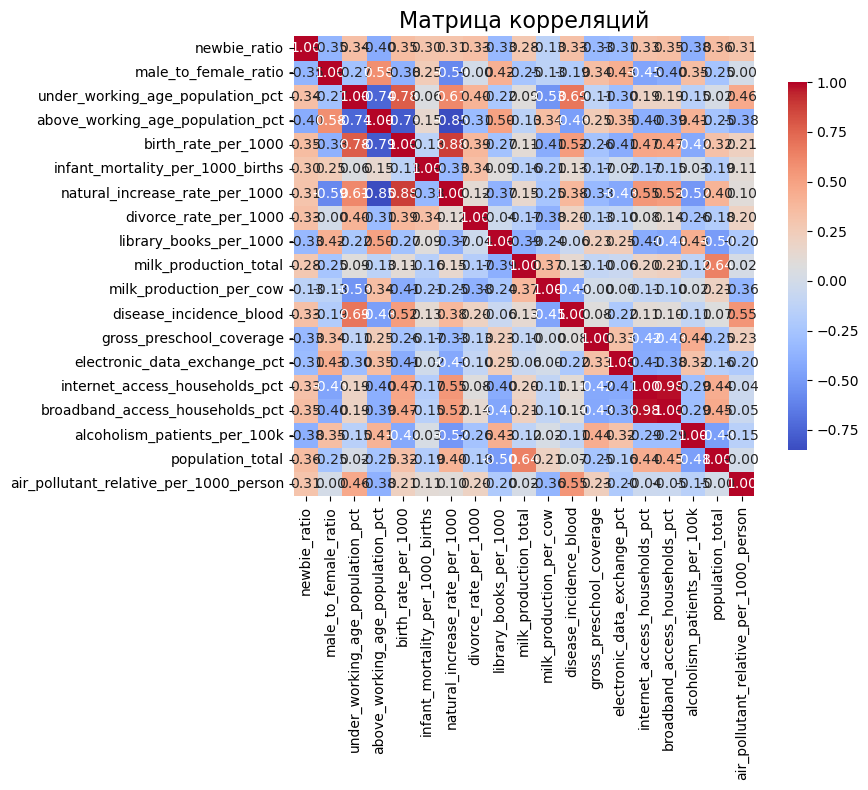

In [246]:
#Дальше Максим
reg_numeric = reg.drop(columns=['region'])  

# Расчет матрицы корреляций  
correlation_matrix = reg_numeric.corr(method='spearman')  

# Настройки визуализации  
plt.figure(figsize=(10, 8))  # Установка размера графика  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})  

# Добавление заголовка  
plt.title('Матрица корреляций', fontsize=16)  
plt.tight_layout()  # Уплотняем график  
plt.show()  

ПОЛУЧАЕТСЯ, что у нас тогда (вчера) когда я делал матрицу, было так мало значимых признаков из-за этих "новых" регионов (5 штук их).
И теперь вон столько у нас значимых корреляций методом спирмена. Снизу сначала вывел жесткие корреляции, а еще ниже эту большую матрицу разделил на несколько частей для удобства рассмотрения.

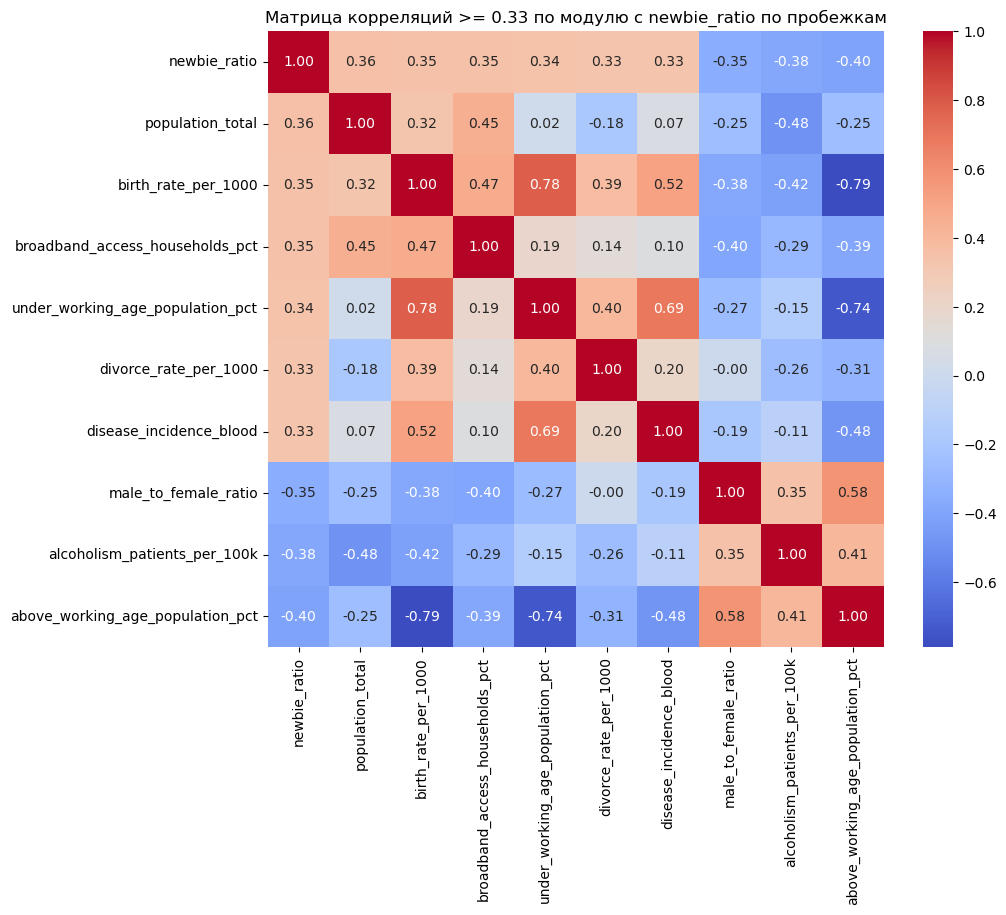

In [247]:
target = 'newbie_ratio'

  
correlation_with_target = reg_numeric.corr(method="spearman")[target].sort_values(ascending=False)  

filtered_features = correlation_with_target[abs(correlation_with_target) >= 0.33].index.tolist()  
correlation_matrix = reg_numeric[filtered_features].corr(method="spearman")  

plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)  
plt.title('Матрица корреляций >= 0.33 по модулю с newbie_ratio по пробежкам')  
plt.show()

Теперь изначальную матрицу разделил на несколько чтобы прям все корреляции рассмотреть.

newbie_ratio теперь в этих матрицах слева внизу и еще справа внизу

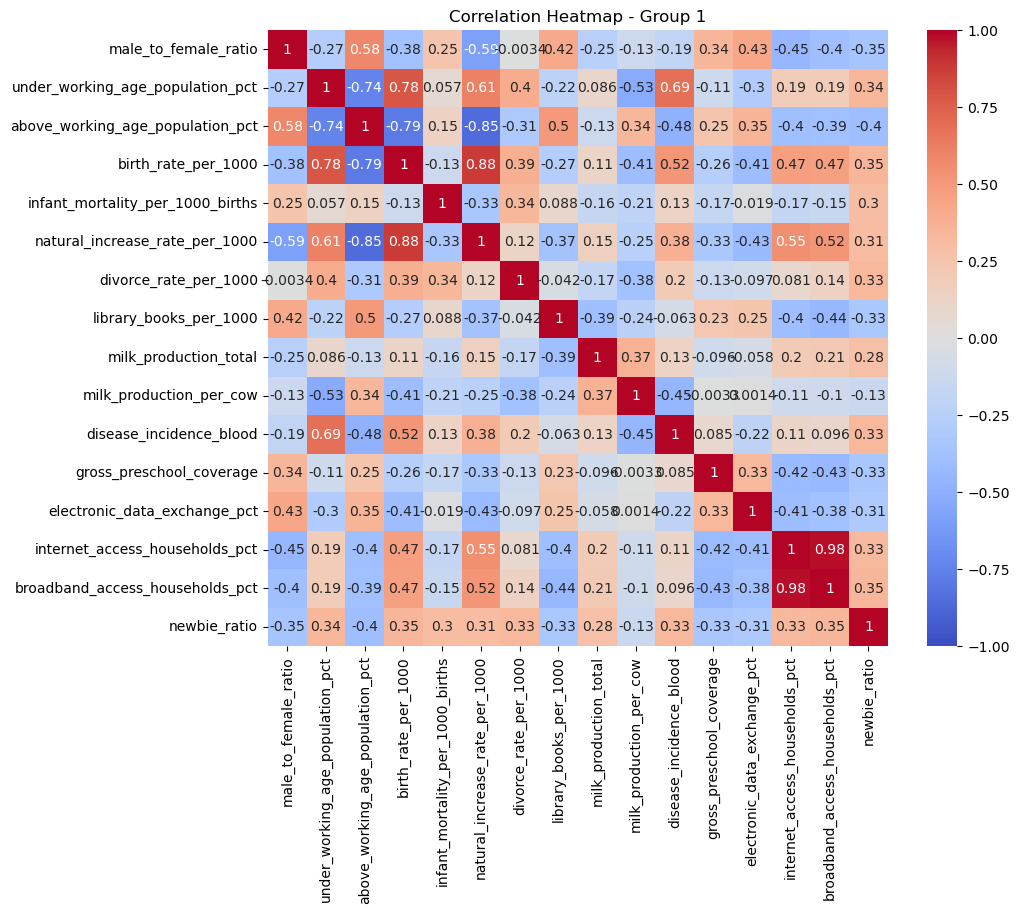

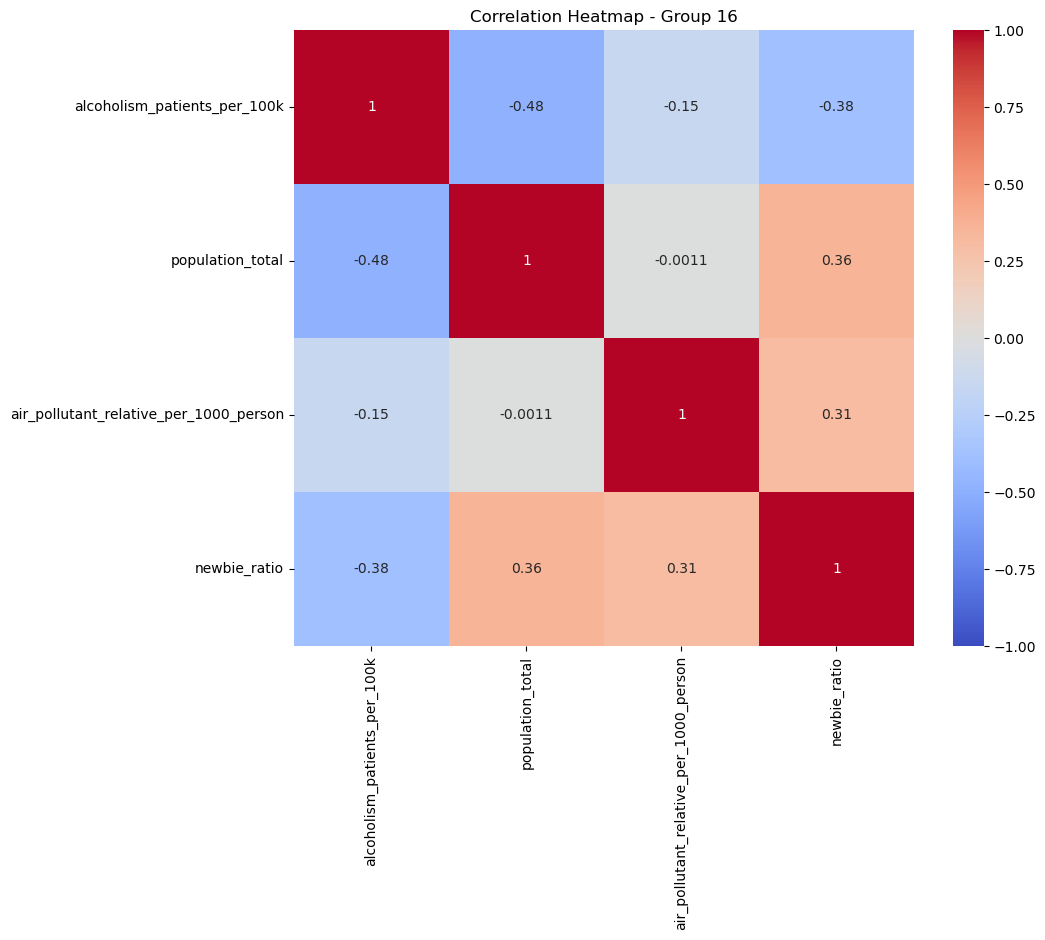

In [248]:
target_variable = 'newbie_ratio'  

# 2. Получите список всех числовых переменных, исключая целевую  
numeric_features = reg_numeric.select_dtypes(include=['float64', 'int64']).columns.tolist()  
numeric_features.remove(target_variable)
group_size = 15  # Например, 5 переменных в группе  

# 4. Разделите переменные на группы  
groups = {f'Group {i+1}': numeric_features[i:i + group_size] for i in range(0, len(numeric_features), group_size)}

for group_name, variables in groups.items():  
    # Выбор переменных из группы и целевой переменной  
    subset = reg_numeric[variables + ['newbie_ratio']]  
    
    # Вычисление корреляционной матрицы  
    corr_matrix = subset.corr(method="spearman")  
    
    # Создание тепловой карты  
    plt.figure(figsize=(10, 8))  
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)  
    
    plt.title(f'Correlation Heatmap - {group_name}')  
    plt.show()  

In [249]:
reg.sort_values(by='newbie_ratio', ascending=False)
print(sum(reg.isnull().sum()))


2


Ниже я просто решил создать новую переменную не Newbie_ratio, а runners_ratio (доля уникальных бегунов по регионам деленная на население региона)


Неподходящие целочисленные переменные: ['per_capita_income_rub', 'median_income_per_capita_rub', 'milk_consumption_per_capita', 'sugar_consumption_per_capita', 'urban_population_pct', 'male_to_female_ratio', 'working_age_population_pct', 'above_working_age_population_pct', 'dependency_ratio', 'birth_rate_per_1000', 'death_rate_per_1000', 'infant_mortality_per_1000_births', 'natural_increase_rate_per_1000', 'marriage_rate_per_1000', 'divorce_rate_per_1000', 'migration_increase_rate_per_10000', 'library_books_per_1000', 'library_users_total', 'forest_coverage_pct', 'disease_incidence_infectious', 'disease_incidence_cancer', 'disease_incidence_blood', 'disease_incidence_endocrine', 'disease_incidence_nervous', 'disease_incidence_ear', 'disease_incidence_circulatory', 'disease_incidence_respiratory', 'disease_incidence_digestive', 'disease_incidence_skin', 'disease_incidence_musculoskeletal', 'disease_incidence_genitourinary', 'disease_incidence_congenital', 'disease_incidence_trauma', 'd

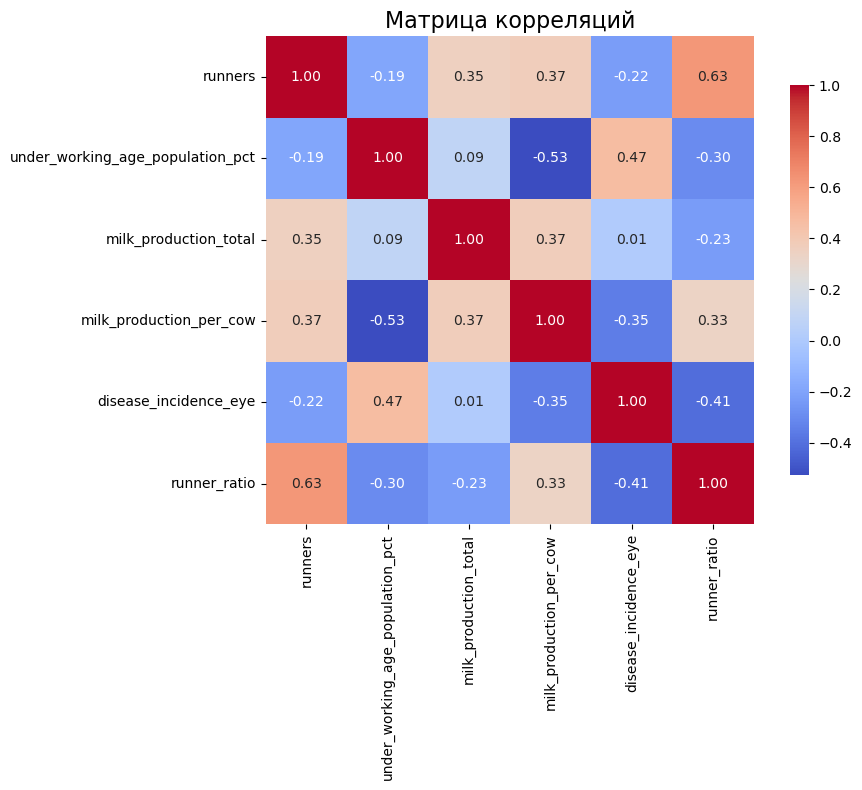

In [250]:
unique_runners = new_df[~new_df['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])].drop_duplicates(subset=['region', 'athlete_id'])
runners_ratios = (
    unique_runners
    .groupby('region', as_index=False)
    .agg(runners=('athlete_id', 'count'))
)
new_reg = runners_ratios.merge(regions, on="region", how="left")
new_reg['runner_ratio'] = new_reg['runners'] / new_reg['population_total']

new_reg['air_pollutant_relative_per_1000_person'] = new_reg['air_pollutant_emissions'] / new_reg['population_total'] * 1000
new_reg = new_reg.drop(columns=['air_pollutant_emissions'])
# Фильтруем только целочисленные столбцы  
integer_columns = new_reg.select_dtypes(include=['number']).columns  

# Переменная для хранения незначимых переменных  
insignificant_vars = []  

# Обходим все целочисленные столбцы  
for col in integer_columns:  
    
    try:
        if col != 'runner_ratio':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(new_reg[col], new_reg['runner_ratio'])  
        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))
# Удаляем незначимые переменные (по корреляции) из датафрейма  
new_reg = new_reg.drop(columns=insignificant_vars)  


reg_numeric = new_reg.drop(columns=['region'])  

# Расчет матрицы корреляций  
correlation_matrix = reg_numeric.corr(method='spearman')  

# Настройки визуализации  
plt.figure(figsize=(10, 8))  # Установка размера графика  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})  

# Добавление заголовка  
plt.title('Матрица корреляций', fontsize=16)  
plt.tight_layout()  # Уплотняем график  
plt.show()  


In [251]:
#Семён что-то делает
factor_corr_matrix = reg.drop(columns=['newbie_ratio', 'region']).corr(method="spearman")
factor_corr_list = (
    factor_corr_matrix
    .stack()
    .reset_index()
    .rename(columns={0: 'correlation', 'level_0': 'factor_1', 'level_1': 'factor_2'})
)
factor_corr_list = factor_corr_list[factor_corr_list['factor_1'] != factor_corr_list['factor_2']].drop_duplicates()
sorted_factor_corr = factor_corr_list.sort_values(by='correlation', ascending=False)
high_corr = sorted_factor_corr[abs(sorted_factor_corr['correlation']) > 0.6]
high_corr = high_corr[high_corr['factor_1'] < high_corr['factor_2']]

In [252]:
high_corr

,factor_1,factor_2,correlation
265,broadband_access_households_pct,internet_access_households_pct,0.980435
59,birth_rate_per_1000,natural_increase_rate_per_1000,0.880222
55,birth_rate_per_1000,under_working_age_population_pct,0.782350
181,disease_incidence_blood,under_working_age_population_pct,0.686199
160,milk_production_total,population_total,0.641498
91,natural_increase_rate_per_1000,under_working_age_population_pct,0.614083
37,above_working_age_population_pct,under_working_age_population_pct,-0.741457
39,above_working_age_population_pct,birth_rate_per_1000,-0.788341
41,above_working_age_population_pct,natural_increase_rate_per_1000,-0.851693


In [253]:
clean_reg = reg.drop(columns=['under_working_age_population_pct'])

In [254]:
clean_reg = clean_reg.drop(columns=['birth_rate_per_1000'])

Выкину еще молоко, тк нелогично + нет значений для спб

In [255]:
clean_reg = clean_reg.drop(columns=['internet_access_households_pct', 'natural_increase_rate_per_1000', 'milk_production_total', 'milk_production_per_cow'])

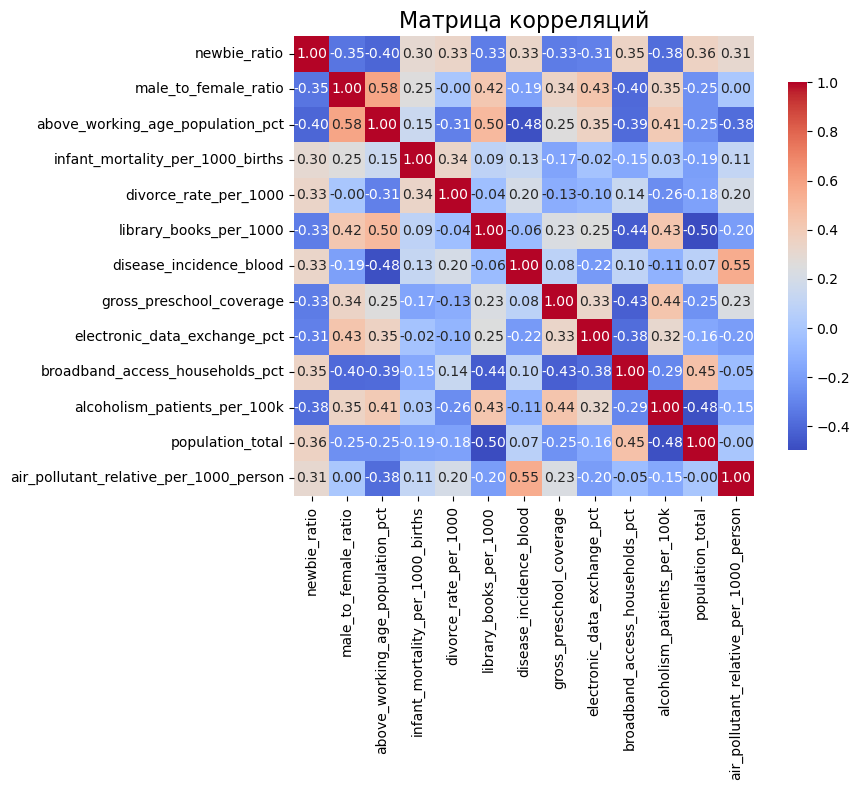

In [256]:
clean_reg_numeric = clean_reg.drop(columns=['region'])
clean_corr_matrix = clean_reg_numeric.corr(method='spearman')
plt.figure(figsize=(10, 8))  
sns.heatmap(clean_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})  
plt.title('Матрица корреляций', fontsize=16)  
plt.tight_layout() 
plt.show()  

In [257]:
clean_reg.head(5)


,region,newbie_ratio,male_to_female_ratio,above_working_age_population_pct,infant_mortality_per_1000_births,divorce_rate_per_1000,library_books_per_1000,disease_incidence_blood,gross_preschool_coverage,electronic_data_exchange_pct,broadband_access_households_pct,alcoholism_patients_per_100k,population_total,air_pollutant_relative_per_1000_person
0,Астраханская область,0.723926,1129.0,22.5,5.6,5.7,6065,3.3,63.033869,51.3,86.6,496.2,957.8,108.582167
1,Белгородская область,0.584507,1158.0,26.9,4.2,4.3,6044,1.6,77.615965,57.2,77.5,598.2,1536.5,102.831110
2,Владимирская область,0.560563,1203.0,28.3,4.2,4.4,6621,1.8,88.628641,60.3,79.2,1392.2,1342.2,54.388318
3,Волгоградская область,0.664502,1135.0,25.8,4.4,4.4,5093,1.8,73.702335,50.3,88.1,590.6,2492.8,87.050706
4,Воронежская область,0.724057,1165.0,27.6,3.6,4.4,5967,2.0,76.131240,55.9,89.7,1284.8,2302.6,49.943542


Строим первую модель (построю OLS для пересчитанных факторов для начала)

In [258]:
target = 'newbie_ratio'
features = clean_reg.drop(columns=[target, 'region'])
features_with_const = sm.add_constant(features)
model = sm.OLS(clean_reg[target], features_with_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           newbie_ratio   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     1.632
Date:                Thu, 05 Dec 2024   Prob (F-statistic):              0.133
Time:                        21:09:50   Log-Likelihood:                 52.300
No. Observations:                  44   AIC:                            -78.60
Df Residuals:                      31   BIC:                            -55.41
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Никаких статзначимых коэффициентов(

Построим ридж-регрессию для этих факторов

In [259]:
X = features
y = clean_reg[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge = Ridge(alpha=1.0)  
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": ridge.coef_})
print(coef_df)


Mean Squared Error: 0.020003104781535705
R^2 Score: -0.7399242644416517
                                   Feature  Coefficient
0                     male_to_female_ratio    -0.000890
1         above_working_age_population_pct    -0.002447
2         infant_mortality_per_1000_births     0.048210
3                    divorce_rate_per_1000     0.025050
4                   library_books_per_1000     0.000003
5                  disease_incidence_blood     0.009543
6                 gross_preschool_coverage     0.002165
7             electronic_data_exchange_pct    -0.001251
8          broadband_access_households_pct     0.000292
9             alcoholism_patients_per_100k    -0.000015
10                        population_total     0.000010
11  air_pollutant_relative_per_1000_person     0.000110


Добавим кросс-валидацию для подбора alpha (коэффициента регуляризации)

In [260]:
alphas = np.logspace(-3, 3, 100)


ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5) 
ridge_cv.fit(X, y)


best_alpha = ridge_cv.alpha_
print(f"Лучшее значение alpha: {best_alpha}")


ridge_optimized = Ridge(alpha=best_alpha)
ridge_optimized.fit(X_train, y_train)


y_pred = ridge_optimized.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))


coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": ridge_optimized.coef_})
print(coef_df)


cv_scores = cross_val_score(ridge_optimized, X, y, scoring='neg_mean_squared_error', cv=5)
print(f"Среднее MSE на кросс-валидации: {np.mean(-cv_scores)}")


Лучшее значение alpha: 1000.0
Mean Squared Error: 0.017048937115389986
R^2 Score: -0.4829627547313933
                                   Feature   Coefficient
0                     male_to_female_ratio -6.939887e-04
1         above_working_age_population_pct -4.328218e-04
2         infant_mortality_per_1000_births  6.691969e-04
3                    divorce_rate_per_1000  4.080214e-04
4                   library_books_per_1000 -5.236577e-07
5                  disease_incidence_blood  5.486749e-04
6                 gross_preschool_coverage  3.955606e-04
7             electronic_data_exchange_pct -6.956635e-04
8          broadband_access_households_pct  5.731066e-04
9             alcoholism_patients_per_100k -1.495073e-05
10                        population_total  6.118653e-07
11  air_pollutant_relative_per_1000_person  1.857832e-04
Среднее MSE на кросс-валидации: 0.015327824124159395


Получается плохо, почти все коэффициенты близко к нулю

In [261]:

alphas = np.logspace(-3, 1, 100)

lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.alpha_
print(f"Лучшее значение alpha: {best_alpha}")

y_pred = lasso_cv.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": lasso_cv.coef_})
print(coef_df)

selected_features = coef_df[coef_df['Coefficient'] != 0]
print("Отобранные признаки:", selected_features)


Лучшее значение alpha: 0.5094138014816381
Mean Squared Error: 0.01658696493152406
R^2 Score: -0.44277916218493085
                                   Feature   Coefficient
0                     male_to_female_ratio -2.188775e-04
1         above_working_age_population_pct -0.000000e+00
2         infant_mortality_per_1000_births  0.000000e+00
3                    divorce_rate_per_1000  0.000000e+00
4                   library_books_per_1000 -5.164368e-06
5                  disease_incidence_blood  0.000000e+00
6                 gross_preschool_coverage -0.000000e+00
7             electronic_data_exchange_pct -0.000000e+00
8          broadband_access_households_pct  0.000000e+00
9             alcoholism_patients_per_100k -2.094318e-05
10                        population_total  8.190243e-07
11  air_pollutant_relative_per_1000_person  1.842618e-04
Отобранные признаки:                                    Feature   Coefficient
0                     male_to_female_ratio -2.188775e-04
4         

Всё так же грустно, очень маленькие коэффициенты, никакой логики

In [265]:
%pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/70/58/2f94976df39470fb00eec2cb4f914dde44cd0df8d96483208bf7db4bc97e/xgboost-2.1.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 108.9 kB/s eta 0:19:07
   ---------------------------------------- 0.0/124.9 MB 145.2 kB/s eta 0:14:20
   ---------------------------------------- 0.0/124.9 MB 151.3 kB/s eta 0:13:46
   ---------------------------------------- 0.1/124.9 MB 233.8 kB/s eta 0:08:55
   ---------------------------------------- 0.1/124.9 MB 400.9 kB/s eta 0:05:12
   ---------------------------------------- 0.3/124.9 MB 780.5 kB/s eta 0:02:40
   ---------------------------------------- 0.4/124.9 MB 1.0 MB/s eta 0:01:59
   ---------------------

In [266]:
import xgboost as xgb

In [267]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.3, max_depth=3)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.017891840370952768


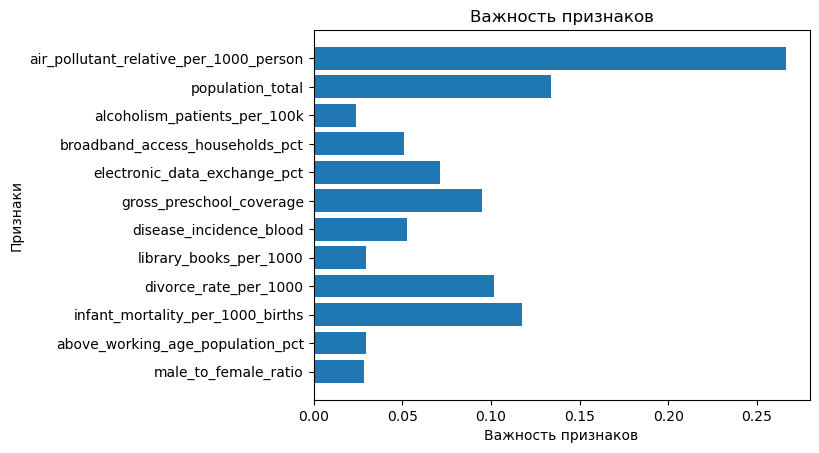

In [269]:
importance = model.feature_importances_

# Визуализация важности
plt.barh(range(len(importance)), importance)
plt.yticks(np.arange(len(importance)), X.columns)  # Замена feature_names на ваши названия признаков
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

In [294]:
import itertools


# X - матрица признаков, y - целевая переменная
mx_coef = 1e-8


def get_p_values_and_coefs(X, y): 
    X_sm = sm.add_constant(X)  # добавляем константу для свободного члена 
    model = sm.OLS(y, X_sm).fit() 
    return model.pvalues, model.params 

# Перебор всех комбинаций признаков 
results = [] 
for k in range(2, len(X.columns)+1):  # начинаем с 2, так как нужны хотя бы две переменные 
    for combo in itertools.combinations(X.columns, k): 
        p_values, coefs = get_p_values_and_coefs(X[list(combo)], y) 
        # Проверяем, есть ли хотя бы две независимые переменные с p-value < 0.05 
        # и коэффициенты >= 0.05
        if (p_values[1:] < 0.05).sum() >= 2 and (coefs[1:] >= 0.05).sum() >= 1:  # пропускаем p-value свободного члена 
            results.append(combo) 
 
# Вывод результатов 
print("Комбинации признаков с хотя бы двумя p-value < 0.05 и coef >= 0.05:")
for combo in results: 
    print(combo)




Комбинации признаков с хотя бы двумя p-value < 0.05 и coef >= 0.05:
('male_to_female_ratio', 'divorce_rate_per_1000', 'population_total')
('divorce_rate_per_1000', 'disease_incidence_blood', 'population_total')
('male_to_female_ratio', 'above_working_age_population_pct', 'infant_mortality_per_1000_births', 'population_total')
('divorce_rate_per_1000', 'library_books_per_1000', 'disease_incidence_blood', 'population_total')
('divorce_rate_per_1000', 'disease_incidence_blood', 'gross_preschool_coverage', 'population_total')
('divorce_rate_per_1000', 'disease_incidence_blood', 'population_total', 'air_pollutant_relative_per_1000_person')
('male_to_female_ratio', 'above_working_age_population_pct', 'infant_mortality_per_1000_births', 'library_books_per_1000', 'population_total')
('divorce_rate_per_1000', 'disease_incidence_blood', 'gross_preschool_coverage', 'broadband_access_households_pct', 'population_total')


In [301]:
feat = clean_reg[['male_to_female_ratio', 'above_working_age_population_pct', 'infant_mortality_per_1000_births', 'library_books_per_1000', 'population_total']].iloc[:40]
y_tr = clean_reg['newbie_ratio'].iloc[:40]

X_tr = sm.add_constant(feat)  # добавляем константу для свободного члена
model = sm.OLS(y_tr, X_tr).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           newbie_ratio   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     2.696
Date:                Thu, 05 Dec 2024   Prob (F-statistic):             0.0372
Time:                        22:04:55   Log-Likelihood:                 46.849
No. Observations:                  40   AIC:                            -81.70
Df Residuals:                      34   BIC:                            -71.56
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [302]:
y_tst = clean_reg['newbie_ratio'].iloc[40:]
feat_tst = clean_reg[['male_to_female_ratio', 'above_working_age_population_pct', 'infant_mortality_per_1000_births', 'library_books_per_1000', 'population_total']].iloc[40:]

# Добавляем константу к новым данным
feat_tst_sm = sm.add_constant(feat_tst)

# Получаем предсказанные значения
predictions = model.predict(feat_tst_sm)

print(predictions)
print()
print(y_tst)

40    0.569563
41    0.624260
42    0.553563
43    0.536474
dtype: float64

40    0.469231
41    0.735499
42    0.553571
43    0.425000
Name: newbie_ratio, dtype: float64


In [303]:
feat = X.iloc[:40]
y_tr = y.iloc[:40]

X_tr = sm.add_constant(feat)  # добавляем константу для свободного члена
model = sm.OLS(y_tr, X_tr).fit()

y_tst = y.iloc[40:]
feat_tst = X.iloc[40:]

# Добавляем константу к новым данным
feat_tst_sm = sm.add_constant(feat_tst)

# Получаем предсказанные значения
predictions = model.predict(feat_tst_sm)

print(predictions)
print()
print(y_tst)

40    0.580437
41    0.617913
42    0.539147
43    0.548774
dtype: float64

40    0.469231
41    0.735499
42    0.553571
43    0.425000
Name: newbie_ratio, dtype: float64


все плохо

In [323]:
starts = pd.read_csv('starts.csv')
volunteers = pd.read_csv('volunteers.csv')



starts['first_run'] = starts.groupby('athlete_id')['event_date'].transform('min')  

# Условие для новичков (это первая пробежка и is_newbie = 1)  
starts['is_first_run'] = (starts['event_date'] == starts['first_run']) & (starts['is_newbie'] == 1)  

  
jogging = starts.groupby(['event_name', 'event_date']).agg(  
    total_participants=('athlete_id', 'nunique'),  # Общее количество участников  
    newbie_count=('is_first_run', 'sum'),   # Количество новичков  
    region = ('region', 'first')
).reset_index()  
jogging['dolya_newbie'] = jogging['newbie_count'] / jogging['total_participants']

jogging = pd.merge(jogging, regions, on='region')

jogging = jogging[~jogging['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]
jogging.head(3)

,event_name,event_date,total_participants,newbie_count,region,dolya_newbie,per_capita_income_rub,median_income_per_capita_rub,milk_consumption_per_capita,sugar_consumption_per_capita,urban_population_pct,male_to_female_ratio,under_working_age_population_pct,working_age_population_pct,above_working_age_population_pct,dependency_ratio,birth_rate_per_1000,death_rate_per_1000,infant_mortality_per_1000_births,natural_increase_rate_per_1000,marriage_rate_per_1000,divorce_rate_per_1000,migration_increase_rate_per_10000,library_books_per_1000,library_users_total,milk_production_total,milk_production_per_cow,forest_coverage_pct,disease_incidence_infectious,disease_incidence_cancer,disease_incidence_blood,disease_incidence_endocrine,disease_incidence_nervous,disease_incidence_eye,disease_incidence_ear,disease_incidence_circulatory,disease_incidence_respiratory,disease_incidence_digestive,disease_incidence_skin,disease_incidence_musculoskeletal,disease_incidence_genitourinary,disease_incidence_congenital,disease_incidence_trauma,disease_incidence_all,air_pollutant_emissions,captured_air_pollutants_pct,wastewater_discharge,gross_preschool_coverage,qualified_workers_grads,mid_level_specialists_grads,bachelors_specialists_masters_grads,electronic_data_exchange_pct,personal_computer_households_pct,internet_access_households_pct,broadband_access_households_pct,daily_internet_usage_pct,bus_passenger_transport,buses_per_100000,unemployed_per_vacancy,stadiums_1500_seats,sports_facilities_fields,sports_facilities_gyms,sports_facilities_pools,alcoholism_patients_per_100k,drug_addiction_patients_per_100k,substance_abuse_patients_per_100k,disabled_population_per_1000,population_total,crimes_murder_attempts,crimes_grievous_bodily_harm,crimes_robbery,crimes_armed_robbery,crimes_hooliganism,crimes_drug_related,nominal_wages_avg_rub,poverty_rate_pct_region
0,Александрино,2023-04-08,89,20,Санкт-Петербург,0.224719,63495,50215.5,309.0,37.0,100.0,1217.0,15.1,59.4,25.5,684,9.0,11.6,3.5,-2.6,10.4,4.8,12.0,9912,1311,NaN,NaN,13.7,32.5,17.0,2.2,15.8,15.8,30.3,31.2,30.5,604.4,32.2,54.5,36.7,49.4,2.3,121.8,171.6,70,25.1,932.7,89.073911,5.6,20.2,64.6,58.7,83.9,87.4,86.6,90.4,558.0,91.606423,0.762024,8.0,2972,2010,395,322.9,160.5,1.3,100.876001,5607.9,134,313,1035,182,108,6570,86630,4.5
1,Александрино,2023-04-15,21,9,Санкт-Петербург,0.428571,63495,50215.5,309.0,37.0,100.0,1217.0,15.1,59.4,25.5,684,9.0,11.6,3.5,-2.6,10.4,4.8,12.0,9912,1311,NaN,NaN,13.7,32.5,17.0,2.2,15.8,15.8,30.3,31.2,30.5,604.4,32.2,54.5,36.7,49.4,2.3,121.8,171.6,70,25.1,932.7,89.073911,5.6,20.2,64.6,58.7,83.9,87.4,86.6,90.4,558.0,91.606423,0.762024,8.0,2972,2010,395,322.9,160.5,1.3,100.876001,5607.9,134,313,1035,182,108,6570,86630,4.5
2,Александрино,2023-04-22,15,6,Санкт-Петербург,0.400000,63495,50215.5,309.0,37.0,100.0,1217.0,15.1,59.4,25.5,684,9.0,11.6,3.5,-2.6,10.4,4.8,12.0,9912,1311,NaN,NaN,13.7,32.5,17.0,2.2,15.8,15.8,30.3,31.2,30.5,604.4,32.2,54.5,36.7,49.4,2.3,121.8,171.6,70,25.1,932.7,89.073911,5.6,20.2,64.6,58.7,83.9,87.4,86.6,90.4,558.0,91.606423,0.762024,8.0,2972,2010,395,322.9,160.5,1.3,100.876001,5607.9,134,313,1035,182,108,6570,86630,4.5



Неподходящие целочисленные переменные: ['milk_consumption_per_capita', 'sugar_consumption_per_capita', 'death_rate_per_1000', 'natural_increase_rate_per_1000', 'migration_increase_rate_per_10000', 'disease_incidence_cancer', 'disease_incidence_eye', 'disease_incidence_ear', 'disease_incidence_respiratory', 'captured_air_pollutants_pct', 'wastewater_discharge', 'gross_preschool_coverage', 'qualified_workers_grads', 'mid_level_specialists_grads', 'electronic_data_exchange_pct', 'personal_computer_households_pct', 'internet_access_households_pct', 'broadband_access_households_pct', 'daily_internet_usage_pct', 'bus_passenger_transport', 'buses_per_100000', 'unemployed_per_vacancy', 'stadiums_1500_seats', 'sports_facilities_gyms', 'sports_facilities_pools', 'disabled_population_per_1000', 'population_total', 'crimes_murder_attempts', 'crimes_grievous_bodily_harm', 'crimes_robbery', 'crimes_armed_robbery', 'crimes_hooliganism', 'crimes_drug_related']
33


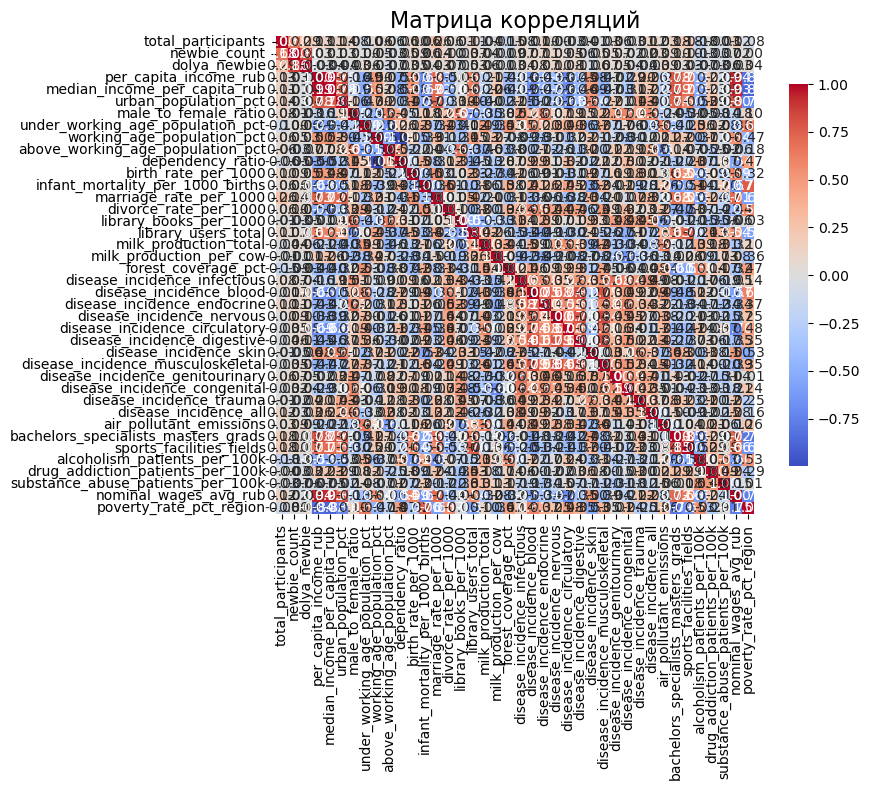

In [324]:
integer_columns = jogging.select_dtypes(include=['number']).columns  

# Переменная для хранения незначимых переменных  
insignificant_vars = []  

# Обходим все целочисленные столбцы  
for col in integer_columns:  
    
    try:
        if col != 'dolya_newbie':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(jogging[col], jogging['dolya_newbie'])  
        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))
# Удаляем незначимые переменные (по корреляции) из датафрейма  
jogging = jogging.drop(columns=insignificant_vars)  

obj_types = jogging.select_dtypes(include=['object']).columns
reg_numeric = jogging.drop(columns=obj_types)  

# Расчет матрицы корреляций  
correlation_matrix = reg_numeric.corr(method='spearman')  

# Настройки визуализации  
plt.figure(figsize=(10, 8))  # Установка размера графика  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})  

# Добавление заголовка  
plt.title('Матрица корреляций', fontsize=16)  
plt.tight_layout()  # Уплотняем график  
plt.show()  


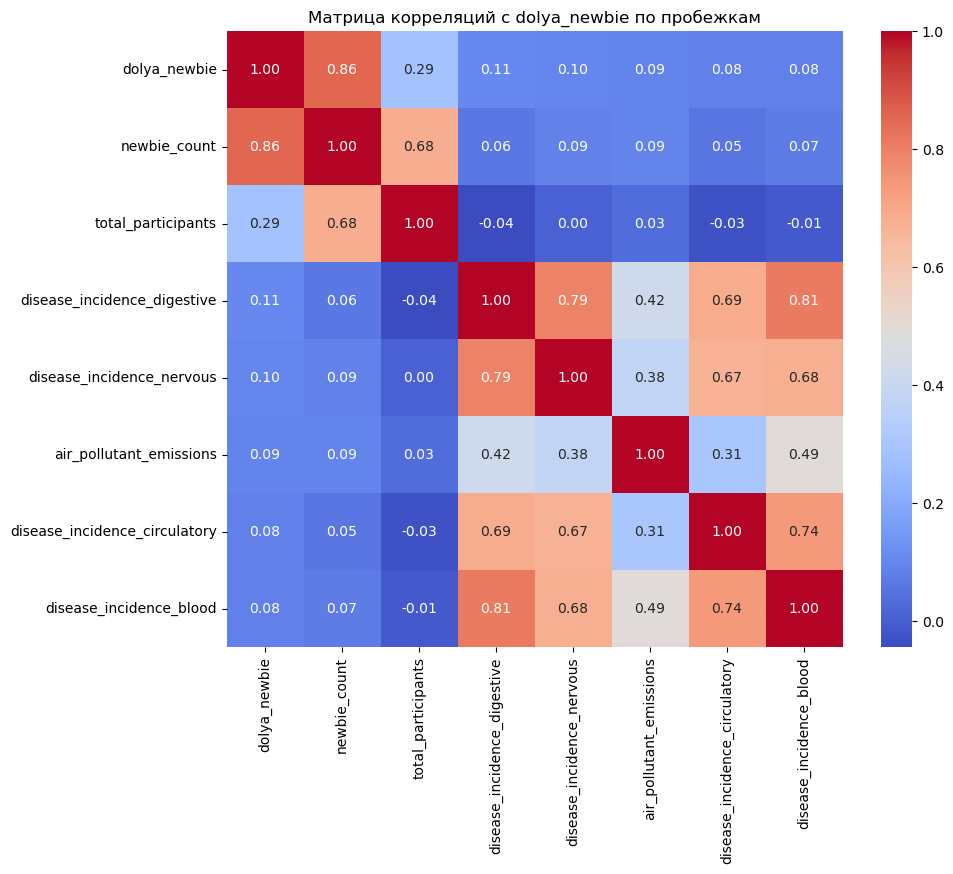

In [325]:
target = 'dolya_newbie'
numeric_df = jogging.select_dtypes(include=['float64', 'int64'])  
  
correlation_with_target = numeric_df.corr(method="spearman")[target].sort_values(ascending=False)  

filtered_features = correlation_with_target[abs(correlation_with_target) >= 0.08].index.tolist()  
correlation_matrix = numeric_df[filtered_features].corr(method='spearman')  

plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)  
plt.title('Матрица корреляций с dolya_newbie по пробежкам')  
plt.show()

In [326]:
new = reg_numeric.drop(columns=['newbie_count', 'total_participants', 'milk_production_per_cow', 'milk_production_total']).dropna()

X_tr = sm.add_constant(new.drop(columns=['dolya_newbie']))  # добавляем константу для свободного члена
y_tr = new['dolya_newbie']
model = sm.OLS(y_tr, X_tr).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           dolya_newbie   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     9.304
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           5.63e-46
Time:                        22:29:04   Log-Likelihood:                 4792.5
No. Observations:                5547   AIC:                            -9515.
Df Residuals:                    5512   BIC:                            -9283.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co